In [1]:
pip install -U imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
df=pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Customer Analytics/Churn Scoring/E Commerce Dataset.xlsx",sheet_name="E Comm")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

# Clean Data

Remove rows contained NaN

In [5]:
df = df.dropna()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3774 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   3774 non-null   int64  
 1   Churn                        3774 non-null   int64  
 2   Tenure                       3774 non-null   float64
 3   PreferredLoginDevice         3774 non-null   object 
 4   CityTier                     3774 non-null   int64  
 5   WarehouseToHome              3774 non-null   float64
 6   PreferredPaymentMode         3774 non-null   object 
 7   Gender                       3774 non-null   object 
 8   HourSpendOnApp               3774 non-null   float64
 9   NumberOfDeviceRegistered     3774 non-null   int64  
 10  PreferedOrderCat             3774 non-null   object 
 11  SatisfactionScore            3774 non-null   int64  
 12  MaritalStatus                3774 non-null   object 
 13  NumberOfAddress   

**Words Cleansing**

On Column PreferredLoginDevice & PreferedOrderCat
- Phone to Mobile Phone

On Column PreferredPaymentMode
- CC to Credit Card
- COD to Cash on Delivery

In [6]:
df.loc[df["PreferredLoginDevice"]=="Phone", 'PreferredLoginDevice'] = "Mobile Phone"
df.loc[df["PreferredPaymentMode"]=="CC", 'PreferredPaymentMode'] = "Credit Card"
df.loc[df["PreferredPaymentMode"]=="COD", 'PreferredPaymentMode'] = "Cash on Delivery"
df.loc[df["PreferedOrderCat"]=="Phone", 'PreferedOrderCat'] = "Mobile Phone"

**One-Hot Encoding**

For convert text to numerical which apply to column
- PreferredLoginDevice
- PreferredPaymentMode
- Gender
- PreferedOrderCat
- MaritalStatus

In [7]:
# Perform one-hot encoding on selected columns

df_encoded = pd.get_dummies(df, columns=['PreferredLoginDevice', 'PreferredPaymentMode','Gender','PreferedOrderCat','MaritalStatus'])

df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3774 entries, 0 to 5629
Data columns (total 33 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   CustomerID                             3774 non-null   int64  
 1   Churn                                  3774 non-null   int64  
 2   Tenure                                 3774 non-null   float64
 3   CityTier                               3774 non-null   int64  
 4   WarehouseToHome                        3774 non-null   float64
 5   HourSpendOnApp                         3774 non-null   float64
 6   NumberOfDeviceRegistered               3774 non-null   int64  
 7   SatisfactionScore                      3774 non-null   int64  
 8   NumberOfAddress                        3774 non-null   int64  
 9   Complain                               3774 non-null   int64  
 10  OrderAmountHikeFromlastYear            3774 non-null   float64
 11  Coup

# Model Creation and Evaluation

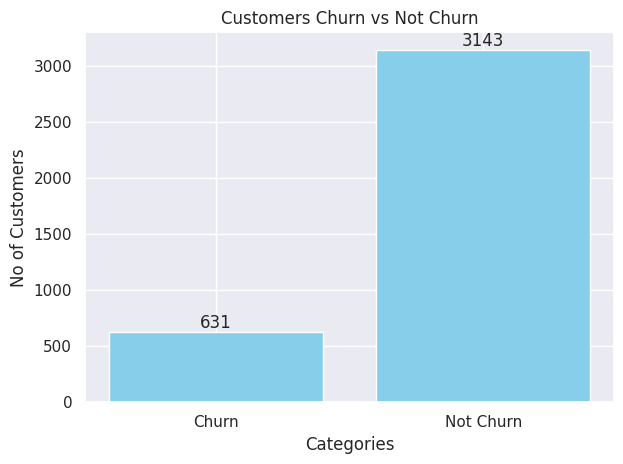

In [8]:
import matplotlib.pyplot as plt

categories = ['Churn', 'Not Churn']
values = [(df_encoded['Churn'] == 1).sum(), (df_encoded['Churn'] == 0).sum()]

# Create a bar chart
plt.bar(categories, values, color='skyblue')

# Add labels and a title
plt.xlabel('Categories')
plt.ylabel('No of Customers')
plt.title('Customers Churn vs Not Churn')

# Add data labels on top of each bar
for i, v in enumerate(values):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

**Prepare Data**

Drop non-features column

In [9]:
df_features=df_encoded.drop(columns=['CustomerID'])

Standardize the features

In [10]:
from sklearn.preprocessing import StandardScaler

#Standardize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features.iloc[:,1:])

Process with imbalance data

In [11]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=0)

sm.fit(df_features.iloc[:,1:], df_features['Churn'])
X_SMOTE, y_SMOTE = sm.fit_resample(df_features.iloc[:,1:], df_features['Churn'])

Separate Train & Test

In [12]:
from sklearn.model_selection import train_test_split

X = X_SMOTE
y = y_SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

Fit Evaluate

In [13]:
#Create Generic function to fit data and display results/predictions
def fit_evaluate(clf, X_train, X_test, y_train, y_test):
    # fit model to training data
    clf.fit(X_train, y_train)

    # make predictions for train data
    y_pred_train = clf.predict(X_train)

    # make predictions for test data
    y_pred_test = clf.predict(X_test)
    # print evaluation
    print(classification_report(y_test, y_pred_test))
    print('\nConfusion Matrix: \n')
    s = sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='g', cmap='YlGnBu');
    s.set(xlabel='Predicted class', ylabel='True class')
    plt.show()

    fpr_train, tpr_train, _ = roc_curve(y_pred_train,  y_train)
    auc_train = roc_auc_score(y_pred_train, y_train)
    plt.plot(fpr_train,tpr_train, color='Blue', label='train: auc='+f'{auc_train:.2f}')

    fpr_test, tpr_test, _ = roc_curve(y_pred_test,  y_test)
    auc_test = roc_auc_score(y_pred_test, y_test)
    plt.plot(fpr_test,tpr_test, color='Red', label='test: auc='+f'{auc_test:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.legend(loc=4)
    plt.show()

Apply K-NN

* SMOTE and K Nearest Neighbors Classifier * 

              precision    recall  f1-score   support

           0       0.99      0.76      0.86      1282
           1       0.80      0.99      0.89      1233

    accuracy                           0.87      2515
   macro avg       0.90      0.88      0.87      2515
weighted avg       0.90      0.87      0.87      2515


Confusion Matrix: 



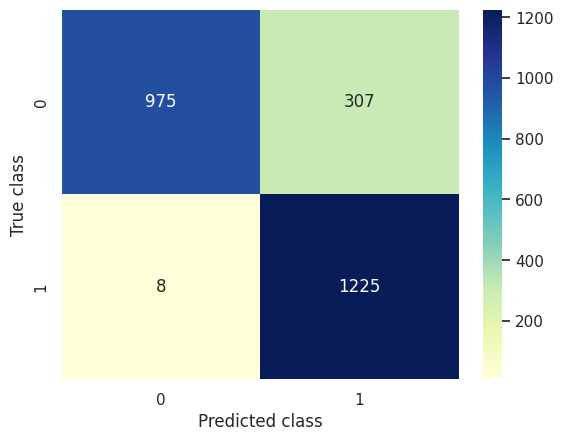

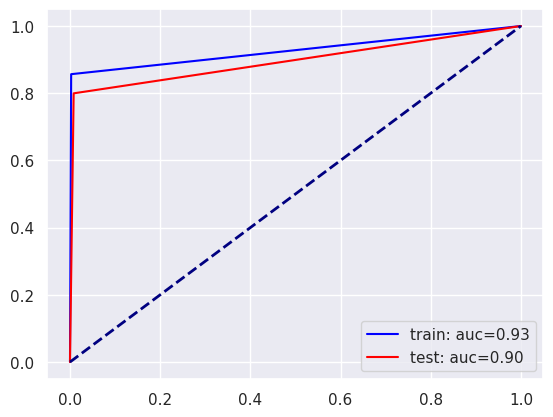

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc

modelKNN = KNeighborsClassifier()

print('* SMOTE and K Nearest Neighbors Classifier * \n')
fit_evaluate(modelKNN, X_train, X_test, y_train, y_test)

Apply Random Forest

* SMOTE and Random Forest Classifier * 

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1282
           1       0.96      0.98      0.97      1233

    accuracy                           0.97      2515
   macro avg       0.97      0.97      0.97      2515
weighted avg       0.97      0.97      0.97      2515


Confusion Matrix: 



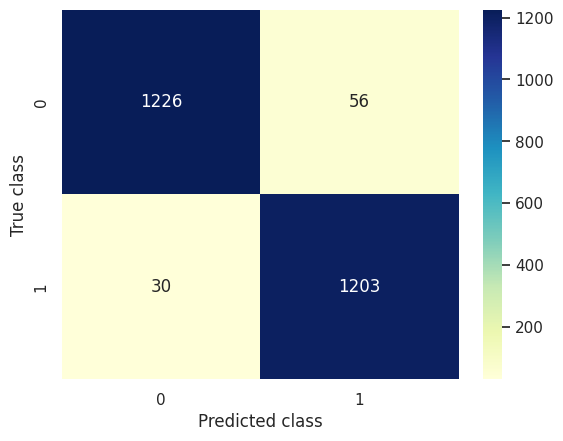

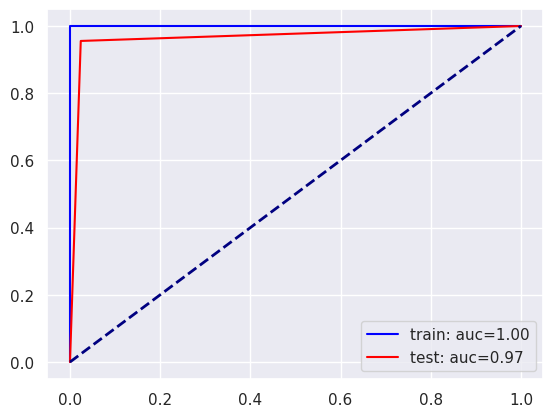

In [16]:
from sklearn.ensemble import RandomForestClassifier

modelRF = RandomForestClassifier()
print('* SMOTE and Random Forest Classifier * \n')
fit_evaluate(modelRF, X_train, X_test, y_train, y_test)

Save Model

In [17]:
import joblib
# Save the trained model to a file
joblib.dump(modelRF, 'random_forest_churn_prediction.pkl')

['random_forest_churn_prediction.pkl']

Load Model

In [18]:
# Load the saved model from a file
loaded_model = joblib.load('random_forest_churn_prediction.pkl')

# Use the loaded model for predictions
predictions = loaded_model.predict(X_SMOTE)

numpy.ndarray

pandas.core.series.Series